In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import cuda

In [9]:
cuda.close()

In [2]:
df = pd.read_csv('../data/minda-corp.csv')
df = df[::-1]
df.head()

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
1221,23-February-2015,99.00,99.80,93.00,93.00,95.314957,2340,46,223037.0,2140.0,91.45,6.80,-6.00
1220,24-February-2015,97.50,97.50,88.35,94.85,92.268180,2819,114,260104.0,1614.0,57.25,9.15,-2.65
1219,25-February-2015,97.95,97.95,91.00,95.00,94.477243,769,36,72653.0,709.0,92.20,6.95,-2.95
1218,26-February-2015,94.50,94.50,90.25,90.90,91.546419,754,12,69026.0,754.0,100.00,4.25,-3.60
1217,27-February-2015,90.00,95.40,89.25,92.75,91.951327,226,63,20781.0,110.0,48.67,6.15,2.75


In [3]:
close_price = df["Close Price"]
time = range(len(close_price))

In [4]:
split_time = 900
price_train = close_price[:split_time]
price_valid = close_price[split_time:]
time_train = time[:split_time]
time_valid = time[split_time:]

In [5]:
def window_dataset(series,window_size,batch_size,shuffle_buffer):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size+1,shift=1,drop_remainder=True)
    data = data.flat_map(lambda window : window.batch(window_size+1))
    data = data.shuffle(shuffle_buffer).map(lambda window: (window[:-1],window[-1]))
    data = data.batch(batch_size).prefetch(1)
    return data

In [6]:
tf.keras.backend.clear_session()

### Simple RNN

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x*100)
])

In [10]:
lr_sch = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(optimizer = optimizer, loss=tf.keras.losses.Huber(),metrics = ['mae'])

In [8]:
tf.random.set_seed(101)
np.random.seed(101)

dataset = window_dataset(price_train, 20, batch_size=32, shuffle_buffer=1000)

In [13]:
history = model.fit(dataset,epochs =100, callbacks=[lr_sch])

Epoch 1/100
28/28 [==============================] - 1s 30ms/step - loss: 142.9652 - mae: 143.4652 - lr: 1.0000e-08
Epoch 2/100
28/28 [==============================] - 1s 25ms/step - loss: 140.1833 - mae: 140.6833 - lr: 1.1220e-08
Epoch 3/100
28/28 [==============================] - 1s 25ms/step - loss: 136.7414 - mae: 137.2414 - lr: 1.2589e-08
Epoch 4/100
28/28 [==============================] - 1s 25ms/step - loss: 132.8312 - mae: 133.3312 - lr: 1.4125e-08
Epoch 5/100
28/28 [==============================] - 1s 25ms/step - loss: 128.4006 - mae: 128.9006 - lr: 1.5849e-08
Epoch 6/100
28/28 [==============================] - 1s 25ms/step - loss: 123.3761 - mae: 123.8761 - lr: 1.7783e-08
Epoch 7/100
28/28 [==============================] - 1s 25ms/step - loss: 117.6727 - mae: 118.1727 - lr: 1.9953e-08
Epoch 8/100
28/28 [==============================] - 1s 25ms/step - loss: 111.1962 - mae: 111.6962 - lr: 2.2387e-08
Epoch 9/100
28/28 [==============================] - 1s 25ms/step - loss

(1e-08, 0.0001, 0.0, 30.0)

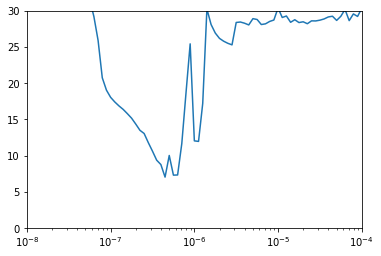

In [14]:
plt.figure()
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [16]:
history.history["loss"].index(min(history.history["loss"]))

33

In [17]:
history.history["lr"][33]

4.466836e-07

In [10]:
optimizer = tf.keras.optimizers.SGD(lr=4.466836e-07,momentum=0.9)
model.compile(optimizer = optimizer, loss=tf.keras.losses.Huber(),metrics = ['mae'])
history = model.fit(dataset,epochs =400)

Epoch 1/400
28/28 [==============================] - 1s 26ms/step - loss: 185.5437 - mae: 186.0437
Epoch 2/400
28/28 [==============================] - 1s 23ms/step - loss: 66.4665 - mae: 66.9648
Epoch 3/400
28/28 [==============================] - 1s 24ms/step - loss: 29.2900 - mae: 29.7852
Epoch 4/400
28/28 [==============================] - 1s 24ms/step - loss: 27.7912 - mae: 28.2814
Epoch 5/400
28/28 [==============================] - 1s 24ms/step - loss: 27.7725 - mae: 28.2682
Epoch 6/400
28/28 [==============================] - 1s 25ms/step - loss: 27.7068 - mae: 28.2009
Epoch 7/400
28/28 [==============================] - 1s 24ms/step - loss: 27.6392 - mae: 28.1329
Epoch 8/400
28/28 [==============================] - 1s 24ms/step - loss: 27.6045 - mae: 28.0983
Epoch 9/400
28/28 [==============================] - 1s 24ms/step - loss: 27.5536 - mae: 28.0480
Epoch 10/400
28/28 [==============================] - 1s 25ms/step - loss: 27.5131 - mae: 28.0049
Epoch 11/400
28/28 [=======

28/28 [==============================] - 1s 24ms/step - loss: 3.8237 - mae: 4.3004
Epoch 170/400
28/28 [==============================] - 1s 26ms/step - loss: 3.3108 - mae: 3.7795
Epoch 171/400
28/28 [==============================] - 1s 25ms/step - loss: 4.5885 - mae: 5.0677
Epoch 172/400
28/28 [==============================] - 1s 24ms/step - loss: 2.9762 - mae: 3.4335
Epoch 173/400
28/28 [==============================] - 1s 24ms/step - loss: 3.8000 - mae: 4.2743
Epoch 174/400
28/28 [==============================] - 1s 24ms/step - loss: 3.3386 - mae: 3.8020
Epoch 175/400
28/28 [==============================] - 1s 29ms/step - loss: 5.7299 - mae: 6.2106
Epoch 176/400
28/28 [==============================] - 1s 30ms/step - loss: 3.0332 - mae: 3.5007
Epoch 177/400
28/28 [==============================] - 1s 25ms/step - loss: 3.1095 - mae: 3.5699
Epoch 178/400
28/28 [==============================] - 1s 25ms/step - loss: 3.1759 - mae: 3.6351
Epoch 179/400
28/28 [=======================

28/28 [==============================] - 1s 27ms/step - loss: 3.1738 - mae: 3.6369
Epoch 338/400
28/28 [==============================] - 1s 25ms/step - loss: 4.2358 - mae: 4.7157
Epoch 339/400
28/28 [==============================] - 1s 24ms/step - loss: 2.8335 - mae: 3.2934
Epoch 340/400
28/28 [==============================] - 1s 25ms/step - loss: 3.8103 - mae: 4.2887
Epoch 341/400
28/28 [==============================] - 1s 25ms/step - loss: 3.5402 - mae: 4.0127
Epoch 342/400
28/28 [==============================] - 1s 26ms/step - loss: 2.3727 - mae: 2.8296
Epoch 343/400
28/28 [==============================] - 1s 26ms/step - loss: 2.9595 - mae: 3.4251
Epoch 344/400
28/28 [==============================] - 1s 26ms/step - loss: 2.7367 - mae: 3.1960
Epoch 345/400
28/28 [==============================] - 1s 26ms/step - loss: 2.5762 - mae: 3.0309
Epoch 346/400
28/28 [==============================] - 1s 25ms/step - loss: 2.6860 - mae: 3.1472
Epoch 347/400
28/28 [=======================

In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [12]:
forecast = []
for time in range(len(close_price) - 20):
    forecast.append(model.predict(tf.expand_dims(close_price[time:time+20],axis=-1)))
    
forecast = forecast[split_time-20:]
results = np.array(forecast)[:,0,0]



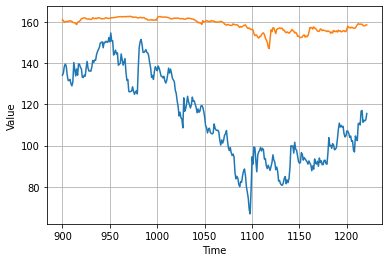

In [13]:

plot_series(time_valid, price_valid)
plot_series(time_valid, results)

In [16]:
print(tf.keras.metrics.mean_absolute_error(price_valid,results).numpy())

44.578045


### Bidirectional LSTM

In [7]:
tf.random.set_seed(101)
np.random.seed(101)

dataset = window_dataset(price_train, 20, batch_size=8, shuffle_buffer=1000)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x*100)
])

In [9]:
optimizer = tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9)
model.compile(optimizer = optimizer, loss=tf.keras.losses.Huber(),metrics = ['mae'])
history = model.fit(dataset,epochs =100)

Epoch 1/100
110/110 [==============================] - 2s 19ms/step - loss: 36.1757 - mae: 36.6717.
Epoch 2/100
110/110 [==============================] - 2s 17ms/step - loss: 22.3534 - mae: 22.8490
Epoch 3/100
110/110 [==============================] - 2s 19ms/step - loss: 16.8249 - mae: 17.3150
Epoch 4/100
110/110 [==============================] - 2s 16ms/step - loss: 12.9152 - mae: 13.4015
Epoch 5/100
110/110 [==============================] - 1s 12ms/step - loss: 12.5484 - mae: 13.0412
Epoch 6/100
110/110 [==============================] - 2s 16ms/step - loss: 10.6622 - mae: 11.1511
Epoch 7/100
110/110 [==============================] - 2s 15ms/step - loss: 8.6997 - mae: 9.1866
Epoch 8/100
110/110 [==============================] - 2s 14ms/step - loss: 8.5520 - mae: 9.0414
Epoch 9/100
110/110 [==============================] - 2s 17ms/step - loss: 9.2606 - mae: 9.7488
Epoch 10/100
110/110 [==============================] - 3s 25ms/step - loss: 7.5641 - mae: 8.0494
Epoch 11/100
110

110/110 [==============================] - 2s 16ms/step - loss: 5.9248 - mae: 6.4040: 0s - loss: 6.1002 - mae: 6.
Epoch 81/100
110/110 [==============================] - 3s 29ms/step - loss: 5.9694 - mae: 6.4481
Epoch 82/100
110/110 [==============================] - 2s 19ms/step - loss: 6.4533 - mae: 6.9387: 0s - loss: 6.0055
Epoch 83/100
110/110 [==============================] - 2s 18ms/step - loss: 5.9719 - mae: 6.4483: 1s - lo
Epoch 84/100
110/110 [==============================] - 2s 15ms/step - loss: 5.3655 - mae: 5.8382
Epoch 85/100
110/110 [==============================] - 2s 15ms/step - loss: 6.0458 - mae: 6.5260
Epoch 86/100
110/110 [==============================] - 1s 12ms/step - loss: 5.5702 - mae: 6.0470
Epoch 87/100
110/110 [==============================] - 1s 13ms/step - loss: 6.1669 - mae: 6.6473
Epoch 88/100
110/110 [==============================] - 1s 11ms/step - loss: 6.5755 - mae: 7.0580
Epoch 89/100
110/110 [==============================] - 2s 14ms/step - los

In [11]:
forecast = []
for time in range(len(close_price) - 20):
    forecast.append(model.predict(tf.expand_dims(close_price[time:time+20],axis=-1)))
    
forecast = forecast[split_time-20:]
results = np.array(forecast)[:,0,0]

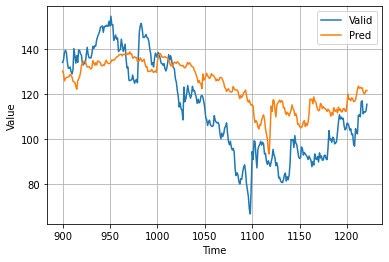

In [17]:
plot_series(time_valid, price_valid)
plot_series(time_valid, results*3)
plt.legend(["Valid","Pred"])


In [18]:
print(tf.keras.metrics.mean_absolute_error(price_valid,results*3).numpy())

14.589261
